#### **5. 합성곱 신경망**
#### **목차**
- 5.1. 합성곱 신경망
- 5.2. 합성곱 신경망 맛보기
- 5.3. 전이 학습
- 5.4. 설명 가능한 CNN
- 5.5. 그래프 합성곱 네트워크

#### **5.1. 합성곱 신경망**
##### 5.1.1 합성곱층의 필요성
- 이미지 데이터의 경우 데이터의 공간적 구조를 무시하지 않기 위해 등장
##### 5.1.2 합성곱 신경망 구조
- 합성곱 신경망의 계층
    - 입력층
    - 합성곱층
    - 풀링층
        - 특성 맵의 차원을 다운 샘플링하여 연산량을 감소
        - 종류
            - 최대 풀링
            - 평균 풀링
    - 완전연결층
    - 출력층
##### 5.1.3 1D,2D,3D 합성곱
- 1D 합성곱
    - 필터가 시간을 축으로 좌우로만 이동할 수 있는 합성곱
    - 출력 형태: 1D 배열
- 3D 입력을 갖는 2D 합성곱


#### **5.2. 합성곱 신경망 맛보기**
- fashion_mnist 데이터셋을 사용하여 합성곱 신경망을 직접 구현해 보기

- 데이터 다운로드

In [3]:
import torchvision
import torchvision.transforms as transforms

train_dataset = torchvision.datasets.FashionMNIST("../chap05/data",download=True,transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("../chap05/data",download=True,train=False,transform=transforms.Compose([transforms.ToTensor()]))


100.0%


Extracting ../chap05/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../chap05/data/FashionMNIST/raw



100.0%


Extracting ../chap05/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../chap05/data/FashionMNIST/raw



100.0%


Extracting ../chap05/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../chap05/data/FashionMNIST/raw



100.0%

Extracting ../chap05/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../chap05/data/FashionMNIST/raw



- 학습 데이터 사이즈와 개수 확인

In [11]:
from data import load_data_using_mini_batch 

# count images in train data set
print(f"Train Data: {len(train_dataset)} images")

# put dataset in torch data loader
mini_batch_size = 100
train_dataloader = load_data_using_mini_batch(train_dataset,mini_batch_size)
test_dataloader = load_data_using_mini_batch(test_dataset,mini_batch_size)

# check image size
images, labels = next(iter(train_dataloader))
print(f"Train Data Image Size: {images.size()} Label Size : {labels.size()}")



Train Data: 60000 images
Train Data Image Size: torch.Size([100, 1, 28, 28]) Label Size : torch.Size([100])


- mac gpu 셋팅

In [15]:
import torch
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'
device = device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(device)

PyTorch version:2.0.1
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-13.4.1-arm64-arm-64bit
mps:0


In [22]:
from models.fashion_dnn_model import FashionDNN


- FashionDNN model 셋팅

In [23]:
learning_rate = 0.001
model = FashionDNN()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


- FashionDNN model train & test

In [24]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images,labels in train_dataloader:
        images,labels = images.to(device),labels.to(device)
        train = images.view(100,1,28,28)
        labels = labels
        outputs = model(train)
        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images,labels in test_dataloader:
                images,labels = images.to(device),labels.to(device)
                labels_list.append(labels)
                test = images.view(100,1,28,28)
                outputs = model(test)
                predictions = torch.max(outputs,1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if not (count % 500):
            print(f"Iteration: {count} Loss: {loss.data} Accuracy: {accuracy}")


Iteration: 500 Loss: 0.4073633551597595 Accuracy: 83.88999938964844
Iteration: 1000 Loss: 0.21681678295135498 Accuracy: 84.93000030517578
Iteration: 1500 Loss: 0.3772657513618469 Accuracy: 85.37999725341797
Iteration: 2000 Loss: 0.3036467730998993 Accuracy: 85.56999969482422
Iteration: 2500 Loss: 0.3027021884918213 Accuracy: 86.11000061035156
Iteration: 3000 Loss: 0.3648817837238312 Accuracy: 85.94000244140625


- FashinCNN 모델 셋팅

In [25]:
from models.fasion_cnn_model import FashionCNN

learning_rate = 0.001
model = FashionCNN()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


- FashionCNN 모델 train & test

In [26]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images,labels in train_dataloader:
        images,labels = images.to(device),labels.to(device)
        train = images.view(100,1,28,28)
        labels = labels
        outputs = model(train)
        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images,labels in test_dataloader:
                images,labels = images.to(device),labels.to(device)
                labels_list.append(labels)
                test = images.view(100,1,28,28)
                outputs = model(test)
                predictions = torch.max(outputs,1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if not (count % 500):
            print(f"Iteration: {count} Loss: {loss.data} Accuracy: {accuracy}")


/Users/hwanghyejeong/.local/share/virtualenvs/23-2_MMStudy_Analysis_F-O1JOBGQa/lib/python3.11/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500 Loss: 0.35280171036720276 Accuracy: 88.93000030517578
Iteration: 1000 Loss: 0.3708013594150543 Accuracy: 88.72000122070312
Iteration: 1500 Loss: 0.23715616762638092 Accuracy: 89.79000091552734
Iteration: 2000 Loss: 0.22042594850063324 Accuracy: 89.44999694824219
Iteration: 2500 Loss: 0.18529856204986572 Accuracy: 91.12999725341797
Iteration: 3000 Loss: 0.16872002184391022 Accuracy: 89.62000274658203


#### **5.3. 전이 학습**
- 전이학습
    - 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용하는 것
    - 방법
        - 특성 추출
        - 미세 조정
##### 5.3.1 특성 추출
- 특성 추출
    - 사전 훈련된 모델에서 완전 연결층(fc layer)만 다시 만든다.
    - 학습할 때는 마지막 완전 연결층만 학습하고 나머지 계층들은 학습되지 않도록 한다.

- 이미지 데이터 전처리 방법 정의

In [29]:
import torchvision.transforms as transforms
transform = transforms.Compose(
    [
        transforms.Resize([256,256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)

- train  데이터 다운로드

In [33]:
data_path = "/Users/hwanghyejeong/Documents/projects/boaz/analysis/23-2_MMStudy_Analysis_F/080289/chap05/data/catanddog/train"
train_dataset = torchvision.datasets.ImageFolder(data_path,transform=transform)

- 학습데이터 개수와 이미지 크기 체크

In [34]:
from data import load_data_using_mini_batch 

# count images in train data set
print(f"Train Data: {len(train_dataset)} images")

# put dataset in torch data loader
mini_batch_size = 32
train_dataloader = load_data_using_mini_batch(train_dataset,mini_batch_size)
test_dataloader = load_data_using_mini_batch(test_dataset,mini_batch_size)

# check image size
images, labels = next(iter(train_dataloader))
print(f"Train Data Image Size: {images.size()} Label Size : {labels.size()}")



Train Data: 385 images
Train Data Image Size: torch.Size([32, 3, 224, 224]) Label Size : torch.Size([32])


- 학습에 사용될 이미지 출력

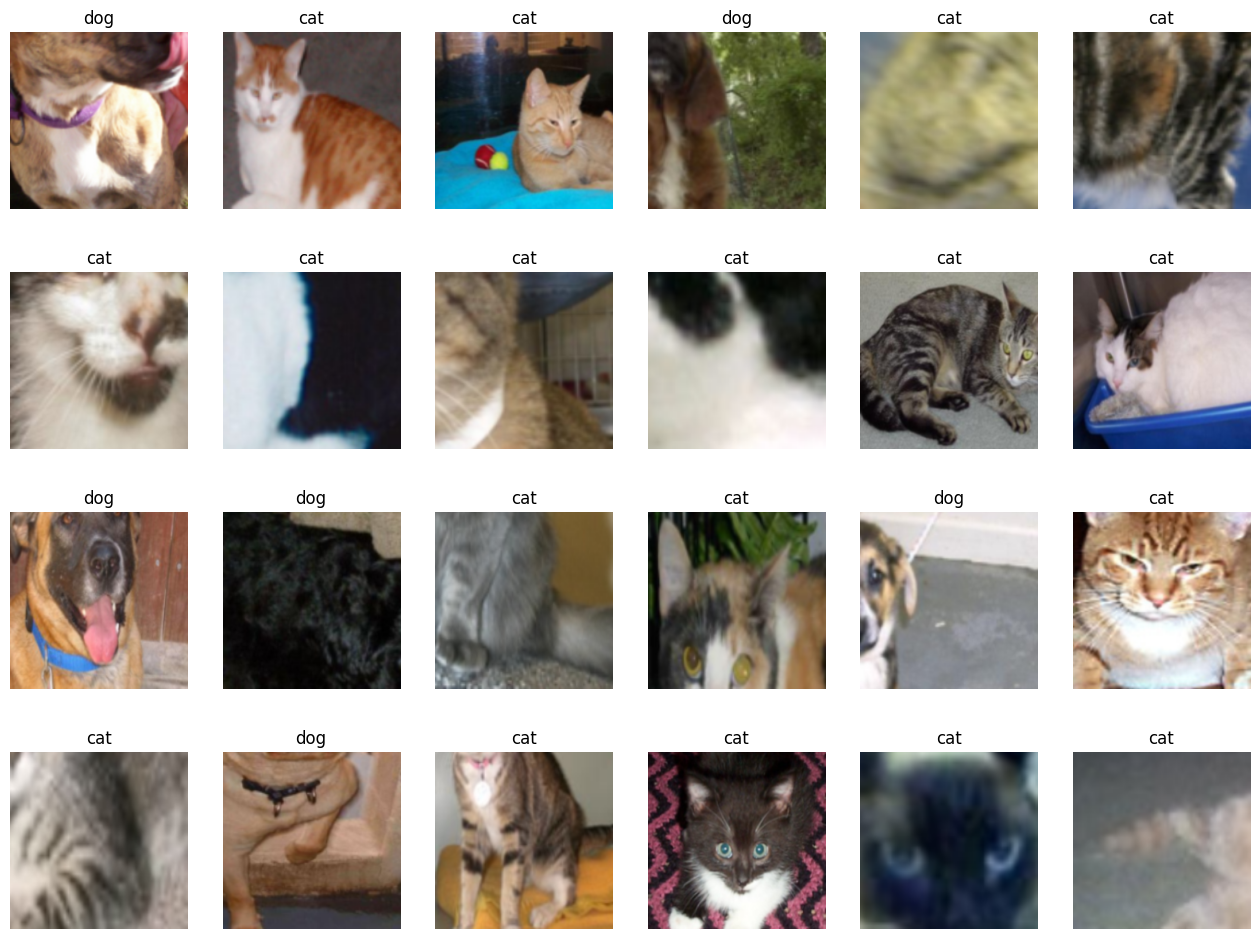

In [37]:
import matplotlib.pyplot as plt
import numpy as np
samples, labels = next(iter(train_dataloader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

- 사전 훈련된 ResNet18 모델셋팅

In [38]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

/Users/hwanghyejeong/.local/share/virtualenvs/23-2_MMStudy_Analysis_F-O1JOBGQa/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hwanghyejeong/.local/share/virtualenvs/23-2_MMStudy_Analysis_F-O1JOBGQa/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/hwanghyejeong/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


- 모델의 convolution layer 와 pooling layer 학습 하지 않게 셋팅

In [39]:
from model_setting import set_parameter_requires_grad
set_parameter_requires_grad(resnet18)

- 모델에 fc layer 추가 후 최종 모델 파라미터 확인

In [41]:
resnet18.fc = torch.nn.Linear(512,2)
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0345, -0.0254,  0.0098,  ..., -0.0228,  0.0149,  0.0093],
        [-0.0188,  0.0026, -0.0171,  ..., -0.0049, -0.0335, -0.0125]])
fc.bias tensor([ 0.0128, -0.0409])
